In [1]:
using JuMP, Gurobi, LinearAlgebra, CSV, DataFrames, Plots

In [2]:
df_areas = CSV.read("P1_areas.csv", DataFrame)
df_clinics = CSV.read("P1_clinics.csv", DataFrame);

In [3]:
# number of residents
n_res = sum(df_areas[:, 3])

# clinic coordinates and capacity
xcl = df_clinics[:, 1]
ycl = df_clinics[:, 2]
c = df_clinics[:, 3];

# resident coordinates and numbers
xres = df_areas[:, 1]
yres = df_areas[:, 2]
r = df_areas[:, 3]

n_areas = size(df_areas[:, 3],1)
n_clinics = size(df_clinics[:, 3],1)

10

In [4]:
m = Model(with_optimizer(Gurobi.Optimizer))
set_optimizer_attribute(m, "OutputFlag", 0)

# variables

# if clinic j is selected
@variable(m, y[j=1:n_clinics], Bin)

# number of residents from area i assigned to clinic j
@variable(m, x[i=1:n_areas, j=1:n_clinics]>=0, Int)

# constraints

# at most 4 clinics built
@constraint(m, sum(y)<=4)

# each resident assigned to one clinic
for i=1:n_areas
    @constraint(m, sum(x[i,j] for j=1:n_clinics)==r[i])
end


for j=1:n_clinics
    @constraint(m, sum(x[i,j] for i=1:n_areas)<=c[j]*y[j])
end


@objective(m, Min, sum(sum(x[i, j]*(abs(xres[i]-xcl[j])+ abs(yres[i]-ycl[j])) for i=1:n_areas) for j=1:n_clinics))
optimize!(m)
JuMP.objective_value(m)

Academic license - for non-commercial use only - expires 2022-08-02


36763.43319948599

In [5]:
x = JuMP.value.(x)
mean_dist = sum(sum(x[i, j]*(abs(xres[i]-xcl[j])+ abs(yres[i]-ycl[j])) for i=1:n_areas) for j=1:10)/n_res
print("Average distance is: ", mean_dist)

Average distance is: 1.8578650292847183

In [6]:
# z[i,j]=1 if there is at least one resident from area i assigned to clinic j
z = zeros(n_areas, 10);

for i=1:n_areas
    for j=1:10
        if x[i,j]>0
            z[i,j] = 1
        else
            z[i,j] = 0
        end
    end
end

In [7]:
max_dist = maximum([z[i, j]*(abs(xres[i]-xcl[j])+ abs(yres[i]-ycl[j])) for i=1:n_areas, j=1:10])
print("Max distance is: ", max_dist)

Max distance is: 3.7314384460000003

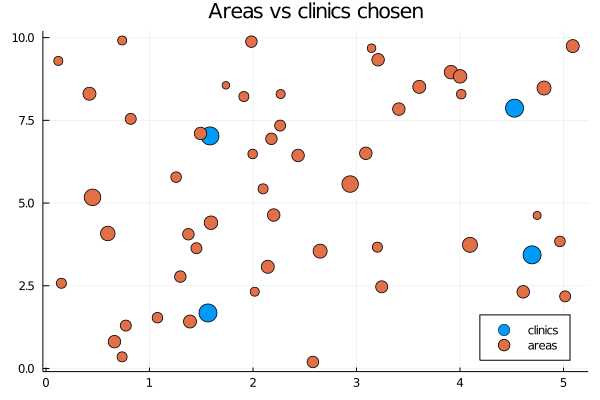

In [8]:
# the size of the areas in the plot is proportional to their population
y = JuMP.value.(y)
scatter([xcl[i] for i=1:n_clinics if y[i]==1], [ycl[i] for i=1:n_clinics if y[i]==1], label="clinics", markersize=10, legend=:bottomright)
scatter!(xres, yres, label="areas", markersize=r/60, title = "Areas vs clinics chosen")